# Topic Modeling

In this lecture, we'll work through an example of *topic modeling*. The idea of topic modeling is to find "topics" in documents that tie together many words. Here are some examples of hypothetical topics that you might find in a newspaper: 

1. **Finance**: "dollar", "stock", "banks"
2. **Politics**: "party", "vote", "election"
3. **Sports**: "team", "win", "game"

In this lecture, we'll see how to use the term-document matrix from last time, in combination with some nice algorithms from `scikit-learn`, to perform topic modeling. Our overall aim is to get a coarse, topic-level summary of the plot of the short book *Alice’s Adventures in Wonderland* by Lewis Carroll. 

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import nltk

# need to do this once to download the data
# nltk.download('gutenberg')

from nltk.corpus import gutenberg

Let's briefly review the steps that we took to construct our term-document matrix. First, we used the `gutenberg` module to read in the raw text of the book, and split it into chapters. 

In [3]:
s = gutenberg.raw('carroll-alice.txt')
chapters = s.split("CHAPTER")[1:]

Then, we created a nice, tidy data frame in which we stored the complete text of each chapter. 

In [4]:
df = pd.DataFrame({
    "chapter" : range(1, len(chapters)+1),
    "text" : chapters
})
df

,chapter,text
0,1,I. Down the Rabbit-Hole\n\nAlice was beginnin...
1,2,II. The Pool of Tears\n\n'Curiouser and curio...
2,3,III. A Caucus-Race and a Long Tale\n\nThey we...
3,4,IV. The Rabbit Sends in a Little Bill\n\nIt w...
4,5,V. Advice from a Caterpillar\n\nThe Caterpill...
5,6,VI. Pig and Pepper\n\nFor a minute or two she...
6,7,VII. A Mad Tea-Party\n\nThere was a table set...
7,8,VIII. The Queen's Croquet-Ground\n\nA large r...
8,9,IX. The Mock Turtle's Story\n\n'You can't thi...
9,10,X. The Lobster Quadrille\n\nThe Mock Turtle s...


Then, and this is the complex part, we used the `CountVectorizer` from `sklearn` to construct the term-document matrix. In this example, I've used a few more of the arguments for `CountVectorizer`. In particular, because I'd like to eventually be able to see how topics evolve between chapters, I use the `max_df` argument to specify that I'd like like to include words that appear in at most 50% of the chapters. 

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(max_df=.5, min_df = 0, stop_words='english')

Next, we can use this `CountVectorizer` to create the term-document matrix and collect it all as a nice, tidy data frame. 

In [19]:
counts = vec.fit_transform(df['text'])
counts = counts.toarray()
count_df = pd.DataFrame(counts, columns=vec.get_feature_names())
df = pd.concat((df, count_df), axis = 1)

In [20]:
df.head(3)

,chapter,text,_i_,abide,able,absence,absurd,acceptance,accident,accidentally,...,years,yelled,yelp,yer,yes,yesterday,young,youth,zealand,zigzag
0,1,I. Down the Rabbit-Hole\n\nAlice was beginnin...,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.017134,0.000000,0.00000,0.0,0.033123,0.0
1,2,II. The Pool of Tears\n\n'Curiouser and curio...,0.026655,0.0,0.031037,0.0,0.00000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.023546,0.00000,0.0,0.000000,0.0
2,3,III. A Caucus-Race and a Long Tale\n\nThey we...,0.000000,0.0,0.000000,0.0,0.02641,0.030752,0.0,0.0,...,0.0,0.0,0.0,0.0,0.015907,0.000000,0.02094,0.0,0.000000,0.0


## On To Topic Modeling

Now we are ready to run our model! Topic modeling is an *unsupervised* machine learning framework, which means that there's no set of true labels `y`. So, we just need to create the variables `X`. To do this, we can ignore the `text` and `chapter` columns. 

In [21]:
X = df.drop(['text', 'chapter'], axis = 1)

There are many algorithms for topic modeling. We will use *nonnegative matrix factorization* or NMF for now. As usual, there are three easy steps: 

1. Import the model we want. 
2. Initialize an instance of the model. 
3. Fit the model on data. 

NMF requires us to specify `n_components`, which is the number of topics to find. Choosing the right number of topics is a bit of an art, but there are also quantitative approaches based on Bayesian statistics that we won't go into here. 

In [22]:
from sklearn.decomposition import NMF
model = NMF(n_components=4, init='random', random_state=0)
model.fit(X)

NMF(init='random', n_components=4, random_state=0)

There are two important parts of NMF. First, we have the topics themselves, which are stored in the `components_` attribute of the model. 

In [23]:
model.components_

array([[0.03137396, 0.06263585, 0.        , ..., 0.3960911 , 0.        ,
        0.06601518],
       [0.01334283, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.0372283 , 0.        , 0.04542973, ..., 0.        , 0.0478289 ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [24]:
model.components_.shape

(4, 4624)

Uh, what does that mean? We can think of each component as a collection of **weights** for each word. We can find the most important words in each component by finding the words where the weights are highest within that component. We can do this with a handy function called `np.argsort()`, which tells you which entries of an array are the largest, second largest, etc.

In [25]:
orders = np.argsort(model.components_, axis = 1)
orders

array([[3390, 1033, 4144, ..., 2357, 3992, 1680],
       [2311, 2674, 2676, ..., 3992,  900, 3212],
       [2311, 2451, 2452, ..., 3465, 2357,   45],
       [   0, 2738, 2740, ..., 3572, 4428, 2116]])

We can then use `numpy` "fancy" indexing to arrange the words in the needed orders. 

In [26]:
important_words = np.array(X.columns)[orders]

# top 10 words in component 3
important_words[0][-20:]

array(['baby', 'baby', 'little', 'little', 'pigeon', 'pigeon', 'footman',
       'footman', 'king', 'king', 'caterpillar', 'caterpillar', 'cat',
       'cat', 'queen', 'queen', 'alice', 'alice', 'said', 'said'],
      dtype=object)

It's convenient to write a function to automate this for us: 

In [27]:
def top_words(X, model, component, num_words):
    orders = np.argsort(model.components_, axis = 1)
    important_words = np.array(X.columns)[orders]
    return important_words[component][-num_words:]

In [28]:
top_words(X, model, 3, 5)

array(['gryphon', 'mock', 'mock', 'turtle', 'turtle'], dtype=object)

The next important aspect of topic modeling is the assignment of topics per document. This is done via weights. We can access this by using the `transform()` method of the model. 

In [29]:
weights = model.transform(X)
weights

array([[0.        , 0.        , 0.21697853, 0.        ],
       [0.        , 0.        , 0.21994591, 0.0015995 ],
       [0.04823538, 0.        , 0.08679701, 0.0036963 ],
       [0.        , 0.00086954, 0.2152255 , 0.        ],
       [0.08741705, 0.        , 0.00209053, 0.00035969],
       [0.08998481, 0.        , 0.01332343, 0.        ],
       [0.        , 0.23572409, 0.02664352, 0.01088784],
       [0.09647769, 0.        , 0.        , 0.        ],
       [0.02901454, 0.00314199, 0.00796224, 0.17639955],
       [0.        , 0.        , 0.        , 0.21729643],
       [0.        , 0.27650157, 0.        , 0.        ],
       [0.05834539, 0.10617004, 0.        , 0.0097226 ]])

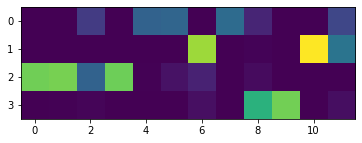

In [30]:
fig, ax = plt.subplots(1)
ax.imshow(weights.T)

The weights indicate the relative presence of each topic in each chapter. For example, Topic 2 is highly present in the first six chapters, but then mostly absent for the rest of the book. Topic 3 appears in Chapters 7 and 11, and so on. 

We can also visualize the same information as a line chart. Let's add as labels some of the top words for each topic. 

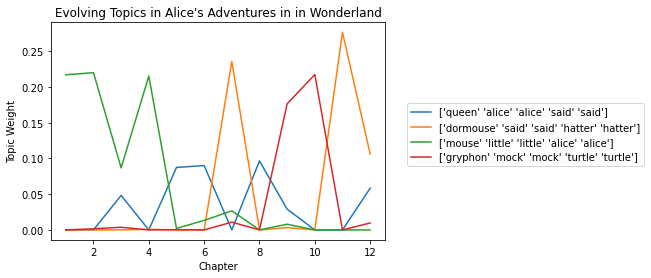

In [31]:
fig, ax = plt.subplots(1)

for i in range(4):
    ax.plot(df['chapter'], weights[:,i], label = top_words(X, model, i, 5))
    
ax.legend(bbox_to_anchor=(1.05, .65), loc='upper left')
t = ax.set(title = "Evolving Topics in Alice's Adventures in in Wonderland",
       xlabel = "Chapter", 
       ylabel = "Topic Weight")

This plot allows us to easily see several major features of the plot of the novel, including the tea party with the March Hare, the Mad Hatter, and the Dormouse (Chapter 7), the crocquet game in the court of the Queen of Hearts (Chapter 8), the appearance of the  Mock Turtle and the Lobster in (Chapters 9 and 10), and the reappearance of many characters in Chapter 11. 